Epoch 1/100


2024-08-20 22:17:31.862256: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


17/17 [==============================] - 2s 30ms/step - loss: 0.0456 - val_loss: 0.0347
Epoch 2/100
17/17 [==============================] - 0s 19ms/step - loss: 0.0295 - val_loss: 0.0262
Epoch 3/100
17/17 [==============================] - 0s 19ms/step - loss: 0.0213 - val_loss: 0.0178
Epoch 4/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0119 - val_loss: 0.0110
Epoch 5/100
17/17 [==============================] - 0s 21ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 6/100
17/17 [==============================] - 0s 25ms/step - loss: 0.0063 - val_loss: 0.0079
Epoch 7/100
17/17 [==============================] - 0s 28ms/step - loss: 0.0067 - val_loss: 0.0115
Epoch 8/100
17/17 [==============================] - 0s 28ms/step - loss: 0.0063 - val_loss: 0.0053
Epoch 9/100
17/17 [==============================] - 0s 27ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 10/100
17/17 [==============================] - 0s 27ms/step - loss: 0.0054 - val_loss: 0.0038
Epoch 11/10

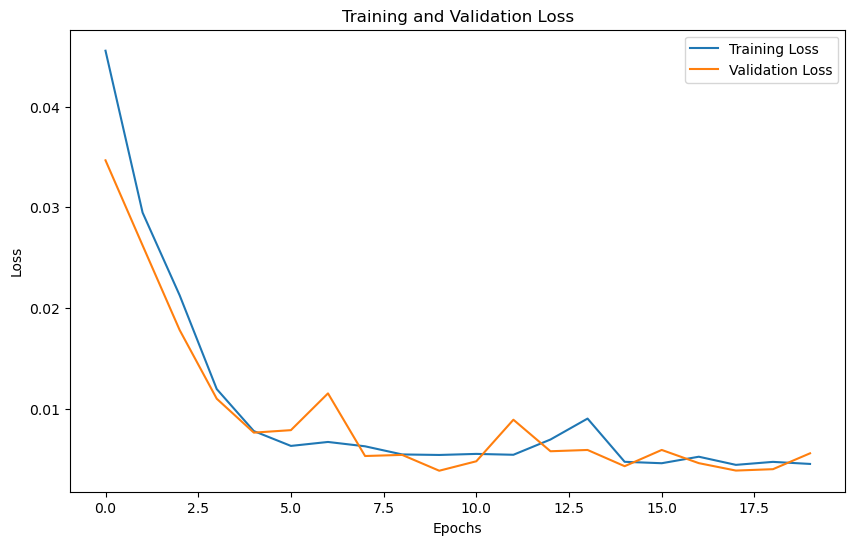

3/3 [==============================] - 0s 6ms/step
EVI - RMSE: 0.021124138027849862, MAE: 0.013490730269327195, MAPE: 6.747748018823946
NDVI - RMSE: 0.026835676154072438, MAE: 0.017890207027725136, MAPE: 6.46152414757338
1/1 [==============================] - 0s 9ms/step


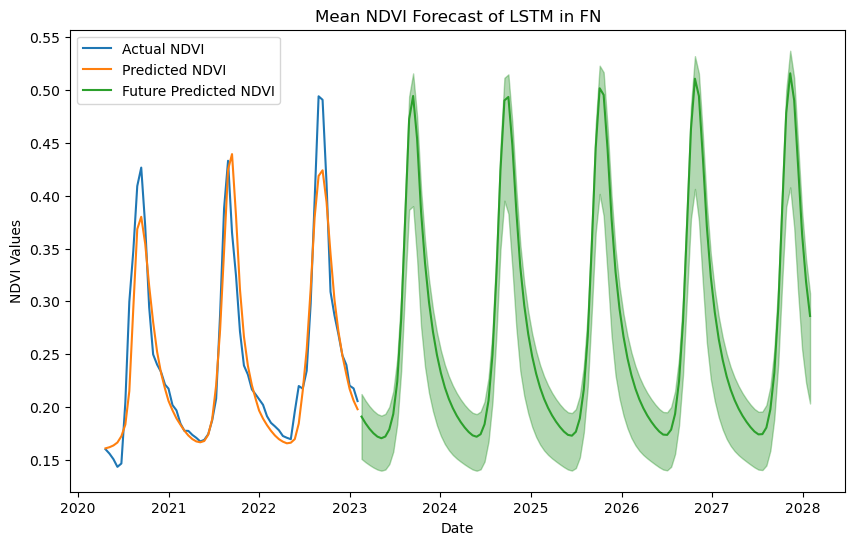

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

file_path = 'merged_FN.csv'
data = pd.read_csv(file_path)
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Normalisation
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data), index=data.index, columns=data.columns)

# Seasonality:yearly
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i + seq_length].values)
        y.append(data.iloc[i + seq_length].values)
    return np.array(X), np.array(y)

# data sequence
seq_length = 23

# Create sequences
X, y = create_sequences(data_normalized, seq_length)

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# LSTM model with optimization
model = Sequential()
model.add(Bidirectional(LSTM(100, activation='relu', input_shape=(seq_length, 2), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, activation='relu')))
model.add(Dropout(0.2))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=16, verbose=1, callbacks=[early_stopping])

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# predictions
predictions = model.predict(X_test)

# Inverse transforming the predictions and actual values
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test)

# RMSE, MAE, and MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

rmse_evi = np.sqrt(mean_squared_error(y_test_inverse[:, 0], predictions_inverse[:, 0]))
mae_evi = mean_absolute_error(y_test_inverse[:, 0], predictions_inverse[:, 0])
mape_evi = mean_absolute_percentage_error(y_test_inverse[:, 0], predictions_inverse[:, 0])

rmse_ndvi = np.sqrt(mean_squared_error(y_test_inverse[:, 1], predictions_inverse[:, 1]))
mae_ndvi = mean_absolute_error(y_test_inverse[:, 1], predictions_inverse[:, 1])
mape_ndvi = mean_absolute_percentage_error(y_test_inverse[:, 1], predictions_inverse[:, 1])

print(f'EVI - RMSE: {rmse_evi}, MAE: {mae_evi}, MAPE: {mape_evi}')
print(f'NDVI - RMSE: {rmse_ndvi}, MAE: {mae_ndvi}, MAPE: {mape_ndvi}')

# Predicting future values with confidence intervals
def predict_future_with_ci(model, data, seq_length, future_steps, ci_multiplier=1.96):
    future_predictions = []
    future_predictions_ci = []
    last_sequence = data[-seq_length:].values
    current_sequence = last_sequence

    prediction_errors = y_test_inverse - predictions_inverse
    prediction_errors_std = np.std(prediction_errors, axis=0)

    for _ in range(future_steps):
        next_pred = model.predict(current_sequence.reshape(1, seq_length, 2))
        future_predictions.append(next_pred[0])

        ci = ci_multiplier * prediction_errors_std
        future_predictions_ci.append((next_pred[0] - ci, next_pred[0] + ci))

        current_sequence = np.append(current_sequence[1:], next_pred, axis=0)

    return np.array(future_predictions), np.array(future_predictions_ci)

# the number of future steps (years)
future_years = 2028 - data.index[-1].year
future_steps = future_years * 365 // 16  # Adjust for 16-day intervals

# Predicting future values with confidence intervals
future_predictions, future_predictions_ci = predict_future_with_ci(model, data_normalized, seq_length, future_steps)

# Inverse transforming future predictions
future_predictions_inverse = scaler.inverse_transform(future_predictions)
future_predictions_ci_inverse = np.array([scaler.inverse_transform(ci) for ci in future_predictions_ci])

# Prepare dates for plotting
dates = pd.date_range(start=data.index[-1], periods=future_steps + 1, freq='16D')[1:]

# Plot the actual vs predicted NDVI values with confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(y_test_inverse):], y_test_inverse[:, 1], label='Actual NDVI')
plt.plot(data.index[-len(predictions_inverse):], predictions_inverse[:, 1], label='Predicted NDVI')
plt.plot(dates, future_predictions_inverse[:, 1], label='Future Predicted NDVI')
plt.fill_between(dates, future_predictions_ci_inverse[:, 1, 0], future_predictions_ci_inverse[:, 1, 1], color='green', alpha=0.3)
plt.title('Mean NDVI Forecast of LSTM in FN')
plt.xlabel('Date')
plt.ylabel('NDVI Values')
plt.legend()
plt.show()

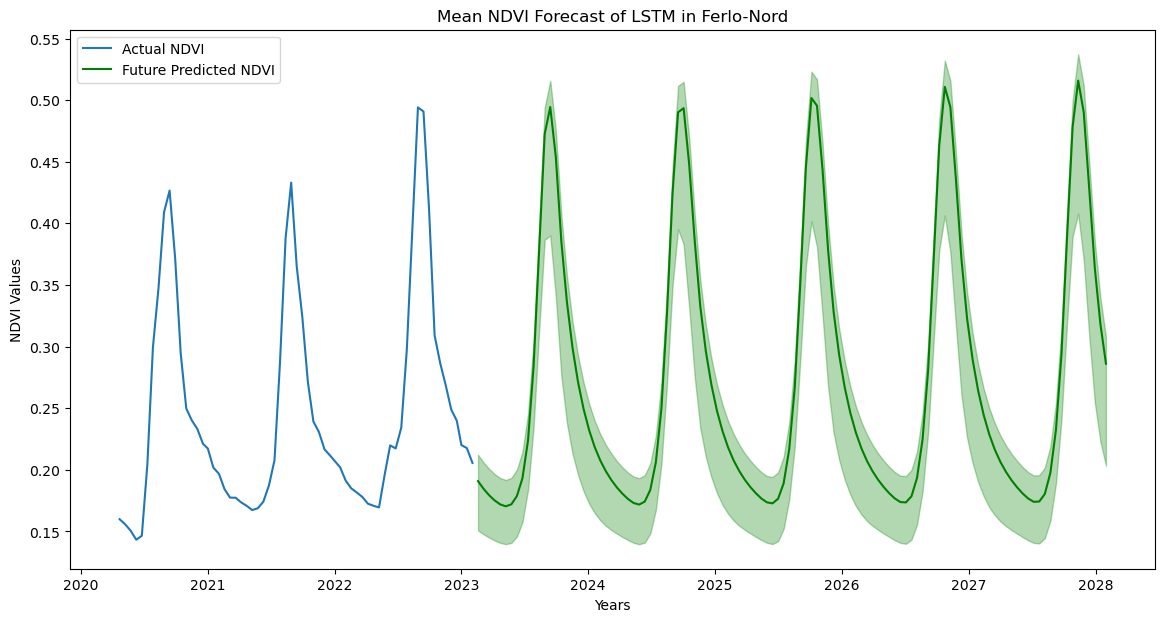

In [2]:
# Adjusted plot for better visualisation
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test_inverse):], y_test_inverse[:, 1], label='Actual NDVI')
plt.plot(dates, future_predictions_inverse[:, 1], color='green', label='Future Predicted NDVI')
plt.fill_between(dates, future_predictions_ci_inverse[:, 1, 0], future_predictions_ci_inverse[:, 1, 1], color='green', alpha=0.3)
plt.title('Mean NDVI Forecast of LSTM in Ferlo-Nord')
plt.xlabel('Years')
plt.ylabel('NDVI Values')
plt.legend()
plt.show()